In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline  
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
spark = SparkSession \
    .builder \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/12/03 16:25:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/03 16:25:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Read in data
flights_2018 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2018.parquet')
flights_2019 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2019.parquet')
flights_2020 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2020.parquet')
flights_2021 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2021.parquet')
flights_2022 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2022.parquet')

In [4]:
"""
Transform data so that each row is an airline and each column is a day. 
The value of each cell is the proportion of flights for that airline on that day 
that had an arrival delay >= 15 minutes.
""" 
remove = ['Peninsula Airways Inc.', 'Virgin America']
# Combine all years, select relevant columns, drop missing
combined = flights_2018.union(flights_2019).union(flights_2020).union(flights_2021).union(flights_2022) \
    .select('FlightDate', 'Airline', 'ArrDel15').dropna()

filtered = combined.filter(~combined['Airline'].isin(remove))
# Group by airline and date, calculate proportion of delayed flights
delay_prop = filtered.groupBy('Airline', 'FlightDate') \
                .agg(F.mean('ArrDel15').alias('delay_proportion'))

# Pivot so each airline is a row and each date is a column
pivoted = delay_prop.groupBy('Airline') \
            .pivot('FlightDate') \
            .agg(F.first('delay_proportion')) \
            .orderBy('Airline')

# Fill NA values with 0
data = pivoted.fillna(0)

print(f'Shape of transformed data: {data.count()} rows, {len(data.columns)} columns.')

[Stage 13:======================================================> (29 + 1) / 30]

Shape of transformed data: 26 rows, 1674 columns.


In [5]:
# Create feature vector
feats = data.columns[1:]
assembler = VectorAssembler(inputCols=feats, outputCol='features')
dataset = assembler.transform(data)

# Show 5 rows
dataset.select('features').show(5)

25/12/03 16:25:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Stage 21:>                                                         (0 + 1) / 1]

25/12/03 16:25:57 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 27:>                                                         (0 + 1) / 1]

25/12/03 16:25:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 31:>                                                         (0 + 1) / 1]

+--------------------+
|            features|
+--------------------+
|[0.52662721893491...|
|[0.16359918200409...|
|[0.34600760456273...|
|[0.0,0.0,0.0,0.0,...|
|(1673,[1,4,7,8,9,...|
+--------------------+
only showing top 5 rows



In [6]:
# Create function to find optimal k
def kmeans_range(lower, upper, data):
    output = pd.DataFrame(columns=['k', 'silhouette'])
    evaluator = ClusteringEvaluator()
    
    # Loop thru k's
    for k in range(lower, upper+1, 1):
        # Instatiate with current k
        kmeans = KMeans().setK(k).setSeed(314).setMaxIter(20)
        
        # Fit
        model = kmeans.fit(data)
        
        # Predict
        preds = model.transform(data)
        
        # Calculate sil score
        sil = evaluator.evaluate(preds)

        # Append to output df
        output = pd.concat([output, pd.DataFrame(data={'k': [k], 'silhouette': [sil]})])
    
    return output.reset_index().drop(columns=['index'])

# Create function to find optimal k
def bkm_range(lower, upper, data):
    output = pd.DataFrame(columns=['k', 'silhouette'])
    evaluator = ClusteringEvaluator()
    
    # Loop thru k's
    for k in range(lower, upper+1, 1):
        # Instatiate with current k
        bkm = BisectingKMeans().setK(k).setSeed(314).setMaxIter(20)
        
        # Fit
        model = bkm.fit(data)
        
        # Predict
        preds = model.transform(data)
        
        # Calculate sil score
        sil = evaluator.evaluate(preds)

        # Append to output df
        output = pd.concat([output, pd.DataFrame(data={'k': [k], 'silhouette': [sil]})])
    
    return output.reset_index().drop(columns=['index'])

In [7]:
# Loop through various k values and view results
comparison_bkm = bkm_range(2, 10, dataset)

[Stage 34:>                                                         (0 + 1) / 1]

25/12/03 16:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:26:05 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 41:======================================================> (29 + 1) / 30]

25/12/03 16:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 49:>                                                         (0 + 1) / 1]

25/12/03 16:26:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:26:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:26:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:14 WARN DAGScheduler: Broadcasting larg

[Stage 159:=====================================================> (29 + 1) / 30]

25/12/03 16:26:20 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:26:20 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 167:>                                                        (0 + 1) / 1]

25/12/03 16:26:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 171:>                                                        (0 + 1) / 1]

25/12/03 16:26:22 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 177:=====================================================> (29 + 1) / 30]

25/12/03 16:26:26 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:26:27 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 185:>                                                        (0 + 1) / 1]

25/12/03 16:26:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 191:=====================================================> (29 + 1) / 30]

25/12/03 16:26:32 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 199:>                                                        (0 + 1) / 1]

25/12/03 16:26:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 209:=====================================================> (29 + 1) / 30]

25/12/03 16:26:38 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:26:39 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 217:>                                                        (0 + 1) / 1]

25/12/03 16:26:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:26:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:26:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:42 WARN DAGScheduler: Broadcasting larg

[Stage 427:=====================================================> (29 + 1) / 30]

25/12/03 16:26:50 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:26:50 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 435:>                                                        (0 + 1) / 1]

25/12/03 16:26:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:26:52 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 445:=====================================================> (29 + 1) / 30]

25/12/03 16:26:56 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:26:56 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 453:>                                                        (0 + 1) / 1]

25/12/03 16:26:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 459:=====================================================> (29 + 1) / 30]

25/12/03 16:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 467:>                                                        (0 + 1) / 1]

25/12/03 16:27:03 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 477:=====================================================> (29 + 1) / 30]

25/12/03 16:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 485:>                                                        (0 + 1) / 1]

25/12/03 16:27:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:27:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:27:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:12 WARN DAGScheduler: Broadcasting larg

[Stage 695:=====================================================> (29 + 1) / 30]

25/12/03 16:27:19 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:27:20 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 703:>                                                        (0 + 1) / 1]

25/12/03 16:27:21 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/12/03 16:27:21 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 713:=====================================================> (29 + 1) / 30]

25/12/03 16:27:25 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:27:26 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 721:>                                                        (0 + 1) / 1]

25/12/03 16:27:27 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 727:=====================================================> (29 + 1) / 30]

25/12/03 16:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 735:>                                                        (0 + 1) / 1]

25/12/03 16:27:33 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 745:=====================================================> (29 + 1) / 30]

25/12/03 16:27:37 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB
25/12/03 16:27:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:27:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:27:42 WARN DAGScheduler: Broadcasting larg

[Stage 1063:====================================================> (29 + 1) / 30]

25/12/03 16:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 1071:>                                                       (0 + 1) / 1]

25/12/03 16:27:52 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1075:>                                                       (0 + 1) / 1]

25/12/03 16:27:53 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 1081:====================================================> (29 + 1) / 30]

25/12/03 16:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 1089:>                                                       (0 + 1) / 1]

25/12/03 16:27:59 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1095:====================================================> (29 + 1) / 30]

25/12/03 16:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 1103:>                                                       (0 + 1) / 1]

25/12/03 16:28:05 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1113:====================================================> (29 + 1) / 30]

25/12/03 16:28:09 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB
25/12/03 16:28:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:28:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:13 WARN DAGScheduler: Broadcasting larg

[Stage 1431:====================================================> (29 + 1) / 30]

25/12/03 16:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:28:23 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 1439:>                                                       (0 + 1) / 1]

25/12/03 16:28:24 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/12/03 16:28:25 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 1449:====================================================> (29 + 1) / 30]

25/12/03 16:28:29 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:28:29 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB
25/12/03 16:28:30 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1463:====================================================> (29 + 1) / 30]

25/12/03 16:28:34 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 1471:>                                                       (0 + 1) / 1]

25/12/03 16:28:36 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1481:====================================================> (29 + 1) / 30]

25/12/03 16:28:40 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:28:41 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 1489:>                                                       (0 + 1) / 1]

25/12/03 16:28:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:28:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:28:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:28:45 WARN DAGScheduler: Broadcasting larg

[Stage 1799:====================================================> (29 + 1) / 30]

25/12/03 16:28:54 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:28:54 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 1807:>                                                       (0 + 1) / 1]

25/12/03 16:28:55 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/12/03 16:28:56 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 1817:====================================================> (29 + 1) / 30]

25/12/03 16:29:00 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:29:01 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 1825:>                                                       (0 + 1) / 1]

25/12/03 16:29:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 1831:====================================================> (29 + 1) / 30]

25/12/03 16:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 1839:>                                                       (0 + 1) / 1]

25/12/03 16:29:07 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 1849:====================================================> (29 + 1) / 30]

25/12/03 16:29:11 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:29:12 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 1857:>                                                       (0 + 1) / 1]

25/12/03 16:29:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:29:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:29:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:16 WARN DAGScheduler: Broadcasting larg

[Stage 2167:====================================================> (29 + 1) / 30]

25/12/03 16:29:25 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:29:25 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 2175:>                                                       (0 + 1) / 1]

25/12/03 16:29:26 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 2179:>                                                       (0 + 1) / 1]

25/12/03 16:29:27 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


[Stage 2185:====================================================> (29 + 1) / 30]

25/12/03 16:29:31 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:29:31 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 2193:>                                                       (0 + 1) / 1]

25/12/03 16:29:32 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 2199:====================================================> (29 + 1) / 30]

25/12/03 16:29:37 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:29:37 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 2207:>                                                       (0 + 1) / 1]

25/12/03 16:29:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 2217:====================================================> (29 + 1) / 30]

25/12/03 16:29:42 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:29:43 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 2225:>                                                       (0 + 1) / 1]

25/12/03 16:29:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:29:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:29:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:29:46 WARN DAGScheduler: Broadcasting larg

[Stage 2635:====================================================> (29 + 1) / 30]

25/12/03 16:29:58 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:29:59 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 2643:>                                                       (0 + 1) / 1]

25/12/03 16:29:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 2647:>                                                       (0 + 1) / 1]

25/12/03 16:30:00 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


[Stage 2653:====================================================> (29 + 1) / 30]

25/12/03 16:30:04 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:30:05 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 2661:>                                                       (0 + 1) / 1]

25/12/03 16:30:06 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 2667:====================================================> (29 + 1) / 30]

25/12/03 16:30:10 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:30:11 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 2675:>                                                       (0 + 1) / 1]

25/12/03 16:30:12 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 2685:====================================================> (29 + 1) / 30]

25/12/03 16:30:16 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:30:17 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB
25/12/03 16:30:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:30:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:20 WARN DAGScheduler: Broadcasting larg

[Stage 3103:====================================================> (29 + 1) / 30]

25/12/03 16:30:31 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:30:32 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3111:>                                                       (0 + 1) / 1]

25/12/03 16:30:33 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3115:>                                                       (0 + 1) / 1]

25/12/03 16:30:34 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


[Stage 3121:====================================================> (29 + 1) / 30]

25/12/03 16:30:38 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:30:38 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3129:>                                                       (0 + 1) / 1]

25/12/03 16:30:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3135:====================================================> (29 + 1) / 30]

25/12/03 16:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3143:>                                                       (0 + 1) / 1]

25/12/03 16:30:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [8]:
comparison_bkm

,k,silhouette
0,2,0.273010
1,3,0.166669
2,4,0.099700
3,5,-0.030948
4,6,0.057427
5,7,0.061663
6,8,0.075417
7,9,0.137496
8,10,0.038644


In [9]:
# Loop through various k values and view results
comparison_km = kmeans_range(2, 10, dataset)

[Stage 3153:====================================================> (29 + 1) / 30]

25/12/03 16:30:49 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:30:50 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3161:>                                                       (0 + 1) / 1]

25/12/03 16:30:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:30:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:30:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3206:====================================================> (29 + 1) / 30]

25/12/03 16:30:57 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:30:58 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3214:>                                                       (0 + 1) / 1]

25/12/03 16:30:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:00 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3224:====================================================> (29 + 1) / 30]

25/12/03 16:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:31:04 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB
25/12/03 16:31:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3238:====================================================> (29 + 1) / 30]

25/12/03 16:31:09 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:31:10 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3246:>                                                       (0 + 1) / 1]

25/12/03 16:31:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3256:====================================================> (29 + 1) / 30]

25/12/03 16:31:15 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3264:>                                                       (0 + 1) / 1]

25/12/03 16:31:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:31:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3309:====================================================> (29 + 1) / 30]

25/12/03 16:31:23 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:31:23 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3317:>                                                       (0 + 1) / 1]

25/12/03 16:31:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:25 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3327:====================================================> (29 + 1) / 30]

25/12/03 16:31:29 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:31:30 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3335:>                                                       (0 + 1) / 1]

25/12/03 16:31:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3341:====================================================> (29 + 1) / 30]

25/12/03 16:31:35 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:31:35 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3349:>                                                       (0 + 1) / 1]

25/12/03 16:31:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3359:====================================================> (29 + 1) / 30]

25/12/03 16:31:40 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:31:41 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3367:>                                                       (0 + 1) / 1]

25/12/03 16:31:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:31:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3422:====================================================> (29 + 1) / 30]

25/12/03 16:31:48 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:31:49 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB
25/12/03 16:31:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:31:51 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3440:====================================================> (29 + 1) / 30]

25/12/03 16:31:55 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:31:55 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3448:>                                                       (0 + 1) / 1]

25/12/03 16:31:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3454:====================================================> (29 + 1) / 30]

25/12/03 16:32:00 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3462:>                                                       (0 + 1) / 1]

25/12/03 16:32:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3472:====================================================> (29 + 1) / 30]

25/12/03 16:32:06 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:32:07 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3480:>                                                       (0 + 1) / 1]

25/12/03 16:32:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:32:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3525:====================================================> (29 + 1) / 30]

25/12/03 16:32:14 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:32:15 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3533:>                                                       (0 + 1) / 1]

25/12/03 16:32:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3537:>                                                       (0 + 1) / 1]

25/12/03 16:32:16 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3543:====================================================> (29 + 1) / 30]

25/12/03 16:32:20 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:32:21 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB
25/12/03 16:32:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3557:====================================================> (29 + 1) / 30]

25/12/03 16:32:26 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:32:27 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3565:>                                                       (0 + 1) / 1]

25/12/03 16:32:28 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 3575:====================================================> (29 + 1) / 30]

25/12/03 16:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB
25/12/03 16:32:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:32:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:32:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3633:====================================================> (29 + 1) / 30]

25/12/03 16:32:40 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:32:40 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3641:>                                                       (0 + 1) / 1]

25/12/03 16:32:41 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 3645:>                                                       (0 + 1) / 1]

25/12/03 16:32:42 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3651:====================================================> (29 + 1) / 30]

25/12/03 16:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:32:47 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3659:>                                                       (0 + 1) / 1]

25/12/03 16:32:47 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 3665:====================================================> (29 + 1) / 30]

25/12/03 16:32:52 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:32:52 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3673:>                                                       (0 + 1) / 1]

25/12/03 16:32:53 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 3683:====================================================> (29 + 1) / 30]

25/12/03 16:32:57 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:32:58 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB
25/12/03 16:32:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:33:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3731:================================================>     (27 + 3) / 30]

25/12/03 16:33:05 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:33:06 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3739:>                                                       (0 + 1) / 1]

25/12/03 16:33:07 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 3743:>                                                       (0 + 1) / 1]

25/12/03 16:33:07 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 3749:====================================================> (29 + 1) / 30]

25/12/03 16:33:11 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:33:12 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3757:>                                                       (0 + 1) / 1]

25/12/03 16:33:13 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 3763:====================================================> (29 + 1) / 30]

25/12/03 16:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:33:18 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3771:>                                                       (0 + 1) / 1]

25/12/03 16:33:18 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 3781:====================================================> (29 + 1) / 30]

25/12/03 16:33:23 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:33:23 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3789:>                                                       (0 + 1) / 1]

25/12/03 16:33:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:33:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3829:====================================================> (29 + 1) / 30]

25/12/03 16:33:30 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:33:31 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB
25/12/03 16:33:32 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/12/03 16:33:33 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 3847:====================================================> (29 + 1) / 30]

25/12/03 16:33:36 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:33:37 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3855:>                                                       (0 + 1) / 1]

25/12/03 16:33:38 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 3861:====================================================> (29 + 1) / 30]

25/12/03 16:33:42 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3869:>                                                       (0 + 1) / 1]

25/12/03 16:33:44 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 3879:====================================================> (29 + 1) / 30]

25/12/03 16:33:48 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:33:48 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3887:>                                                       (0 + 1) / 1]

25/12/03 16:33:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:33:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:33:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 3922:====================================================> (29 + 1) / 30]

25/12/03 16:33:55 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:33:56 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3930:>                                                       (0 + 1) / 1]

25/12/03 16:33:57 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 3934:>                                                       (0 + 1) / 1]

25/12/03 16:33:58 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 3940:====================================================> (29 + 1) / 30]

25/12/03 16:34:01 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:34:02 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3948:>                                                       (0 + 1) / 1]

25/12/03 16:34:03 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 3954:====================================================> (29 + 1) / 30]

25/12/03 16:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:34:08 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 3962:>                                                       (0 + 1) / 1]

25/12/03 16:34:09 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 3972:====================================================> (29 + 1) / 30]

25/12/03 16:34:13 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 3980:>                                                       (0 + 1) / 1]

25/12/03 16:34:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:34:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:34:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:34:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:34:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:34:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:34:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:34:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 4015:====================================================> (29 + 1) / 30]

25/12/03 16:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 4023:>                                                       (0 + 1) / 1]

25/12/03 16:34:22 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 4027:>                                                       (0 + 1) / 1]

25/12/03 16:34:23 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 4033:====================================================> (29 + 1) / 30]

25/12/03 16:34:26 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 4041:>                                                       (0 + 1) / 1]

25/12/03 16:34:28 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 4047:====================================================> (29 + 1) / 30]

25/12/03 16:34:32 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB
25/12/03 16:34:34 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


In [10]:
comparison_km

,k,silhouette
0,2,0.267439
1,3,0.200708
2,4,0.220803
3,5,0.029894
4,6,0.138684
5,7,0.237992
6,8,0.017708
7,9,0.186921
8,10,0.147243


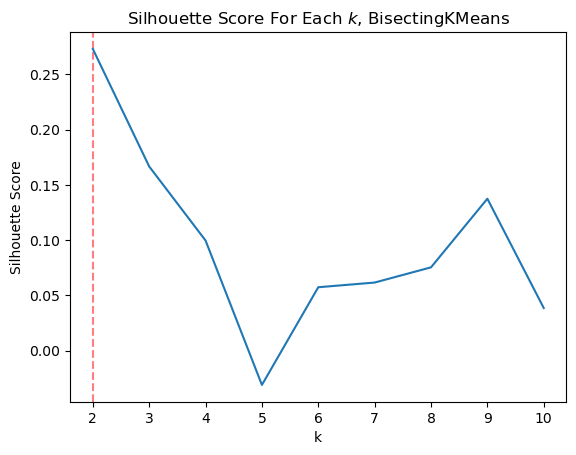

In [11]:
# Visualize
x=comparison_bkm.k
y=comparison_bkm.silhouette
optimal_k = comparison_bkm.loc[comparison_bkm['silhouette'].idxmax(), 'k']
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.5, label=f'Optimal k={int(optimal_k)}')
plt.plot(x, y)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Each $k$, BisectingKMeans')
plt.savefig('airline_bkm_silhouette_scores.png')
plt.show()

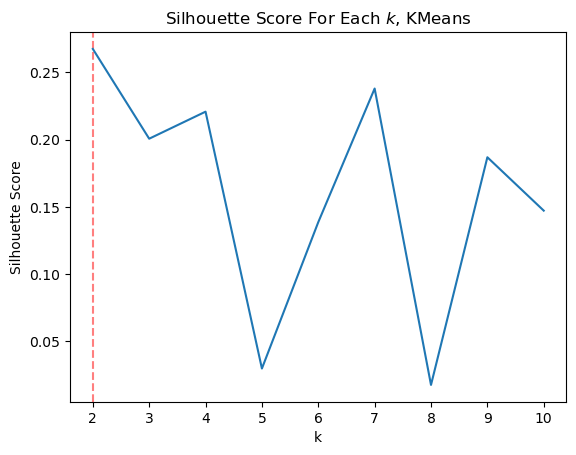

In [12]:
# Visualize
x=comparison_km.k
y=comparison_km.silhouette
optimal_k = comparison_km.loc[comparison_km['silhouette'].idxmax(), 'k']
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.5, label=f'Optimal k={int(optimal_k)}')
plt.plot(x, y)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Each $k$, KMeans')
plt.savefig('airline_km_silhouette_scores.png')
plt.show()

In [13]:
# Refit with k=2
kmeans = KMeans().setK(2).setSeed(314).setMaxIter(20)
# Fit
model = kmeans.fit(dataset)
        
# Predict
km_preds = model.transform(dataset)

[Stage 4065:====================================================> (29 + 1) / 30]

25/12/03 16:37:46 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 4073:>                                                       (0 + 1) / 1]

25/12/03 16:37:48 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:37:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:37:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:37:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:37:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:37:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:37:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:37:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:37:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:37:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 4118:====================================================> (29 + 1) / 30]

25/12/03 16:37:54 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:37:55 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB
25/12/03 16:37:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:37:56 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [14]:
# Refit with k=2
bkm = BisectingKMeans().setK(2).setSeed(314).setMaxIter(20)
# Fit
model = bkm.fit(dataset)
        
# Predict
bkm_preds = model.transform(dataset)

[Stage 4136:====================================================> (29 + 1) / 30]

25/12/03 16:38:04 WARN DAGScheduler: Broadcasting large task binary with size 1473.7 KiB


25/12/03 16:38:05 WARN DAGScheduler: Broadcasting large task binary with size 1475.5 KiB


[Stage 4144:>                                                       (0 + 1) / 1]

25/12/03 16:38:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:38:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:38:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:38:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:38:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:38:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:38:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:38:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:38:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:38:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:38:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:38:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:38:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:38:09 WARN DAGScheduler: Broadcasting larg

[Stage 4254:====================================================> (29 + 1) / 30]

25/12/03 16:38:14 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:38:14 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 4262:>                                                       (0 + 1) / 1]

25/12/03 16:38:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 4266:>                                                       (0 + 1) / 1]

25/12/03 16:38:16 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [15]:
km_preds.select('Airline', 'prediction').orderBy('prediction').show(30, truncate=False)

[Stage 4272:====================================================> (29 + 1) / 30]

25/12/03 16:38:29 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:38:30 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB
25/12/03 16:38:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 4284:>                                                       (0 + 1) / 1]

+-----------------------------------------+----------+
|Airline                                  |prediction|
+-----------------------------------------+----------+
|American Airlines Inc.                   |0         |
|Allegiant Air                            |0         |
|Air Wisconsin Airlines Corp              |0         |
|United Air Lines Inc.                    |0         |
|GoJet Airlines, LLC d/b/a United Express |0         |
|JetBlue Airways                          |0         |
|Commutair Aka Champlain Enterprises, Inc.|0         |
|Mesa Airlines Inc.                       |0         |
|Republic Airlines                        |0         |
|Envoy Air                                |0         |
|SkyWest Airlines Inc.                    |0         |
|Southwest Airlines Co.                   |0         |
|Frontier Airlines Inc.                   |0         |
|Spirit Air Lines                         |0         |
|Alaska Airlines Inc.                     |1         |
|Cape Air 

In [16]:
bkm_preds.select('Airline', 'prediction').orderBy('prediction').show(30, truncate=False)

[Stage 4285:====================================================> (29 + 1) / 30]

25/12/03 16:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 4293:>                                                       (0 + 1) / 1]

25/12/03 16:38:48 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
+-----------------------------------------+----------+
|Airline                                  |prediction|
+-----------------------------------------+----------+
|Cape Air                                 |0         |
|American Airlines Inc.                   |0         |
|Alaska Airlines Inc.                     |0         |
|Trans States Airlines                    |0         |
|Delta Air Lines Inc.                     |0         |
|Empire Airlines Inc.                     |0         |
|Capital Cargo International              |0         |
|Endeavor Air Inc.                        |0         |
|Envoy Air                                |0         |
|Comair Inc.                              |0         |
|ExpressJet Airlines Inc.                 |0         |
|Hawaiian Airlines Inc.                   |0         |
|Compass Airlines                         |0         |
|Horizon Air                      

In [17]:
km_preds_df = km_preds.toPandas()

[Stage 4298:====================================================> (29 + 1) / 30]

25/12/03 16:39:29 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:39:30 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB


[Stage 4306:>                                                       (0 + 1) / 1]

25/12/03 16:39:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


In [18]:
bkm_preds_df = bkm_preds.toPandas()

[Stage 4311:====================================================> (29 + 1) / 30]

25/12/03 16:39:37 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


25/12/03 16:39:38 WARN DAGScheduler: Broadcasting large task binary with size 1477.6 KiB
25/12/03 16:39:39 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


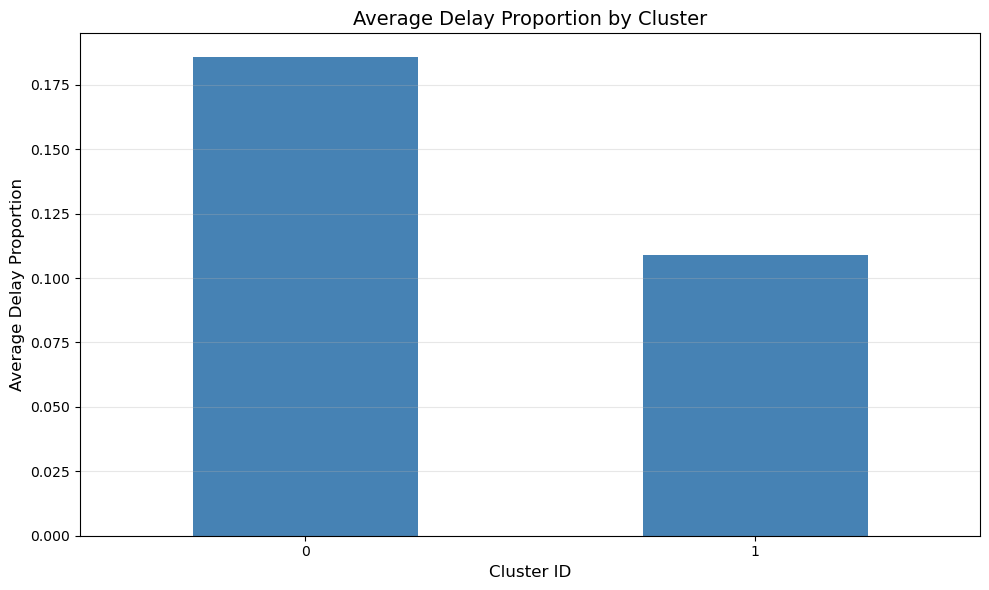

In [20]:
# Calculate average delay proportion per cluster
cluster_stats = km_preds_df.groupby('prediction')[feats].mean().mean(axis=1)
cluster_stats = cluster_stats.sort_values(ascending=False)

# Visualize cluster delay patterns
plt.figure(figsize=(10, 6))
cluster_stats.plot(kind='bar', color='steelblue')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Average Delay Proportion', fontsize=12)
plt.title('Average Delay Proportion by Cluster', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('airline_clustering_delay_proportion_kmeans.png')
plt.show()

#### So with $k=4$, which has the highest silhouette score, we can see how each airline is clustered. Virginia America is the only airline in group 4, so could be worth exploring the clusters.

In [39]:
# Refit with k=2
bkm = BisectingKMeans().setK(2).setSeed(314).setMaxIter(20)
# Fit
model_bkm = bkm.fit(dataset)
        
# Predict
preds_bkm = model_bkm.transform(dataset)

preds_bkm.select('Airline', 'prediction').orderBy('prediction').show(30, truncate=False)

[Stage 4226:====================================================> (29 + 1) / 30]

25/12/03 02:22:21 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:22:22 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 4234:>                                                       (0 + 1) / 1]

25/12/03 02:22:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:22:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:26 WARN DAGScheduler: Broadcasting larg

[Stage 4344:====================================================> (29 + 1) / 30]

25/12/03 02:22:31 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:22:32 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 4352:>                                                       (0 + 1) / 1]

25/12/03 02:22:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 4356:>                                                       (0 + 1) / 1]

25/12/03 02:22:34 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 4362:====================================================> (29 + 1) / 30]

25/12/03 02:22:38 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:22:39 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 4370:>                                                       (0 + 1) / 1]

25/12/03 02:22:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
+----------------------------------------+----------+
|Airline                                 |prediction|
+----------------------------------------+----------+
|Capital Cargo International             |0         |
|Delta Air Lines Inc.                    |0         |
|Hawaiian Airlines Inc.                  |0         |
|Horizon Air                             |0         |
|Empire Airlines Inc.                    |0         |
|Trans States Airlines                   |0         |
|Virgin America                          |0         |
|Compass Airlines                        |0         |
|Endeavor Air Inc.                       |0         |
|ExpressJet Airlines Inc.                |0         |
|Air Wisconsin Airlines Corp             |1         |
|Envoy Air                               |1         |
|Alaska Airlines Inc.                    |1         |
|Frontier Airlines Inc.                  |1       